In [1]:
import os

import matplotlib.pyplot as plt
import xarray as xr

from src import data_catalog
from src import tseries_mod
from src import esmlab_wrap
from src.config import grid_dir
from src.utils import repl_coord, smooth, da_normalize, da_w_lags, regression_slope
from src.utils_plot import plot_1var

In [2]:
data_catalog.set_catalog('cesm_coupled')

active catalog: cesm_coupled


In [3]:
varnames = {'atm': ['TS'],
            'lnd': ['NEE', 'GPP', 'NPP', 'AR', 'TOTVEGC', 'HR', 'COL_FIRE_CLOSS', 'TOTSOMC', 'TSA', 'RAIN', 'TSOI_10CM', 'SOILLIQ'],
           }

ds_dict = {}
for component in varnames:
    ds_dict[component] = {}

for experiment in ['piControl', 'esm-piControl']:
    for component in varnames:
        ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

for experiment in ['piControl-cmip5', 'esm-piControl-cmip5']:
    for component in varnames:
        if component == 'atm':
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

legend_dict = {'piControl': 'piControl, CESM2',
               'esm-piControl': 'esm-piControl, CESM2',
               'piControl-cmip5': 'piControl, CESM1(BGC)',
               'esm-piControl-cmip5': 'esm-piControl, CESM1(BGC)',
              }

In [4]:
def lnd_depth_avg(dz, zlim, da):
    vert_dim = da.dims[1]
    vert_dim_len = da.sizes[vert_dim]

    # restrict dz to layers of da
    dz_vert_dim = dz.dims[0]
    dz_for_da = dz.isel({dz_vert_dim: slice(0, vert_dim_len)}).rename({dz_vert_dim: vert_dim})

    # construct layer bounds
    layer_bot = dz_for_da.cumsum(dim=vert_dim)
    layer_top = layer_bot.shift({vert_dim: 1}, fill_value=0.0)

    # compute weights for averaging
    frac = (zlim - layer_top) / (layer_bot - layer_top)
    weight = xr.where(frac > 1.0, 1.0, xr.where(frac < 0.0, 0.0, frac)) * dz_for_da
    weight = weight / weight.sum(dim=vert_dim)

    # add vertical coordinate to da
    da = da.assign_coords({vert_dim: dz_for_da[vert_dim]})
    da_out = (da * weight).sum(vert_dim)
    return da_out

In [5]:
# add SOILLIQ_10CM, SOILLIQ_TOT to Datasets
for experiment, ds in ds_dict['lnd'].items():
    if 'cmip5' in experiment:
        grid_fname = 'CESM1-BGC.clm2.h0.Time_constant_3Dvars.nc'
    else:
        grid_fname = 'CESM2.clm2.h0.Time_constant_3Dvars.nc'
    print(f"experiment={experiment}, grid_fname={grid_fname}")
    with xr.open_dataset(os.path.join(grid_dir, grid_fname)) as ds_grid:
        # verify assumption that dz is independent of lat and lon
        dz_max = ds_grid['DZSOI'].max(dim=['lat', 'lon'])
        dz_min = ds_grid['DZSOI'].min(dim=['lat', 'lon'])
        assert dz_max.equals(dz_min)
        ds['SOILLIQ_10CM'] = lnd_depth_avg(dz_max, 0.1, ds['SOILLIQ'])
        SOILLIQ_vert_dim = ds['SOILLIQ'].dims[1]
        ds['SOILLIQ_TOT'] = ds['SOILLIQ'].sum(SOILLIQ_vert_dim)

experiment=piControl, grid_fname=CESM2.clm2.h0.Time_constant_3Dvars.nc
experiment=esm-piControl, grid_fname=CESM2.clm2.h0.Time_constant_3Dvars.nc
experiment=piControl-cmip5, grid_fname=CESM1-BGC.clm2.h0.Time_constant_3Dvars.nc
experiment=esm-piControl-cmip5, grid_fname=CESM1-BGC.clm2.h0.Time_constant_3Dvars.nc


In [6]:
def corr_anal(varname_pair, expr_list, component_pair=('atm', 'lnd'), region_x='nino34',
              region_y_list=['Global', 'CentralAfrica', 'MaritimeContinent', 'Australia',
                             'TropSAmer', 'SSAmer'],
              lag_values = range(-18,18+1)):
    max_pos_lag = max([0, max(lag_values)])
    min_neg_lag = min([0, min(lag_values)])
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    print(f"component_x={component_x},component_y={component_y}")
    linestyle_list = [
        'solid',
        (0, (4, 1)),
        (0, (6, 2, 1, 2)),
        (0, (6, 3)),
        (0, (6, 6)),
        (0, (6, 2, 1, 2, 1, 2)),
        (0, (6, 6)),
    ]
    _, ax_corr_coeff = plt.subplots(nrows=1, ncols=len(expr_list), figsize=(10, 8), sharey=True)
    _, ax_regress_slope = plt.subplots(nrows=1, ncols=len(expr_list), figsize=(10, 8), sharey=True)
    small_lag_slope_0 = {}
    for expr_ind, experiment in enumerate(expr_list):
        print(f'varname_x={varname_x}, region_x={region_x}, varname_y={varname_y}, experiment={experiment}')
        plot_dict = {}
        for region_y in region_y_list:
            # construct da_x
            tb_name = ds_dict[component_x][experiment]['time'].attrs['bounds']
            ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict[component_x][experiment][[tb_name, varname_x]])
            iseldict = {}
            if 'lev' in ds_x[varname_x].dims:
                iseldict['lev'] = -1
            for dimname in ['levgrnd', 'levsoi']:
                if dimname in ds_x[varname_x].dims:
                    iseldict[dimname] = 0
            if region_x == 'region_y':
                da_x = ds_x[varname_x].sel(region=region_y).isel(iseldict)
            else:
                da_x = ds_x[varname_x].sel(region=region_x).isel(iseldict)

            # construct da_y
            # replace time with ds_x's time, so that vars are aligned in corr computation
            tb_name = ds_dict[component_y][experiment]['time'].attrs['bounds']
            ds_tmp = repl_coord('time', ds_x, ds_dict[component_y][experiment][[tb_name, varname_y]])
            ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp)
            ds_y = repl_coord('time', ds_x, ds_y)
            iseldict = {}
            if 'lev' in ds_y[varname_y].dims:
                iseldict['lev'] = -1
            for dimname in ['levgrnd', 'levsoi']:
                if dimname in ds_y[varname_y].dims:
                    iseldict[dimname] = 0
            da_y = ds_y[varname_y].sel(region=region_y).isel(iseldict)

            # apply smoothing to da_x and da_y
            smooth_edge_len = 0
            if True:
                for da in [da_x, da_y]:
                    da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
                    da -= da_sm

            # compute lagged correlation between varname_x and varname_y
            da_x_norm = da_normalize(da_x)
            da_y_norm = da_normalize(da_y)
            da_xy_corr = (da_x_norm * da_w_lags(da_y_norm, lag_values=lag_values)).mean('time')
            da_xy_corr.attrs['long_name'] = f'lagged correlation between {varname_x} and {varname_y}'

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_w_lags = da_w_lags(da_y, lag_values=lag_values)
            da_slope = regression_slope(
                da_x.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag)),
                da_y_w_lags.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag))
            )

            plot_dict[region_y] = xr.Dataset({'xy_corr': da_xy_corr, 'slope': da_slope})

        plot_1var('xy_corr', [plot_dict[region_y] for region_y in region_y_list],
                  region_y_list, linestyle_list=linestyle_list, handlelength=6.0,
                  title=legend_dict[experiment], show_ylabel=(expr_ind==0), show_legend=(expr_ind==0),
                  ax=ax_corr_coeff[expr_ind], linewidth=2.0)
        ax_corr_coeff[expr_ind].grid(True)
        ax_corr_coeff[expr_ind].set_ylim((-1.0, 1.0))

        plot_1var('slope', [plot_dict[region_y] for region_y in region_y_list],
                  region_y_list, linestyle_list=linestyle_list, handlelength=6.0,
                  title=legend_dict[experiment], show_ylabel=(expr_ind==0), show_legend=(expr_ind==0),
                  ax=ax_regress_slope[expr_ind], linewidth=2.0)
        ax_regress_slope[expr_ind].grid(True)

        for region_y in region_y_list:
            slope = plot_dict[region_y]['slope'].sel(lag=range(max(min(lag_values), -3),4)).mean('lag').values
            if expr_ind == 0:
                small_lag_slope_0[region_y] = slope
                print(f"{region_y}: {slope:0.3f}")
            else:
                slope_diff = small_lag_slope_0[region_y] - slope
                print(f"{region_y}: {slope:0.3f}, {slope_diff:0.3f}")
    plt.show()

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=piControl
Global: 0.266
CentralAfrica: 0.002
MaritimeContinent: 0.042
Australia: 0.067
TropSAmer: 0.105
SSAmer: 0.003
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=piControl-cmip5
Global: 0.580, -0.314
CentralAfrica: -0.010, 0.012
MaritimeContinent: 0.117, -0.074
Australia: 0.205, -0.138
TropSAmer: 0.179, -0.075
SSAmer: -0.056, 0.060


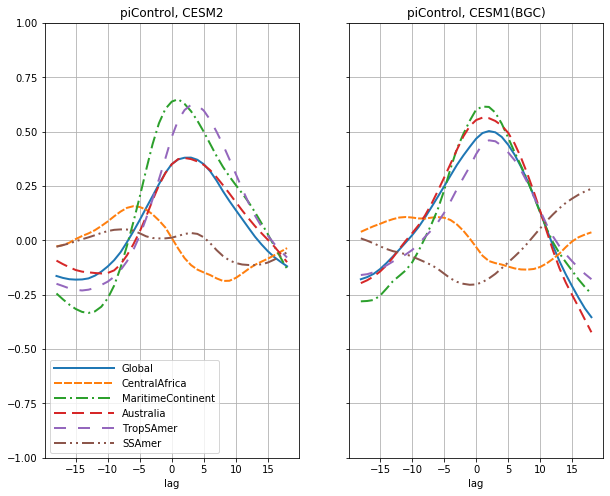

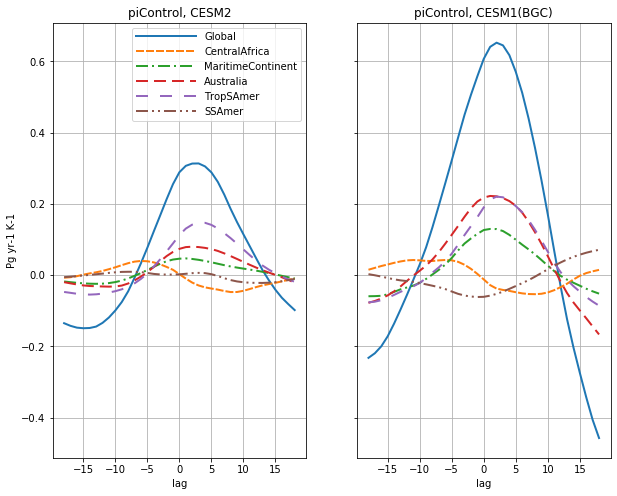

In [7]:
corr_anal(('TS', 'NEE'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=piControl
Global: 0.266
CentralAfrica: 0.002
MaritimeContinent: 0.042
Australia: 0.067
TropSAmer: 0.105
SSAmer: 0.003
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=esm-piControl
Global: 0.269, -0.004
CentralAfrica: -0.004, 0.006
MaritimeContinent: 0.042, 0.000
Australia: 0.073, -0.006
TropSAmer: 0.104, 0.001
SSAmer: -0.000, 0.004


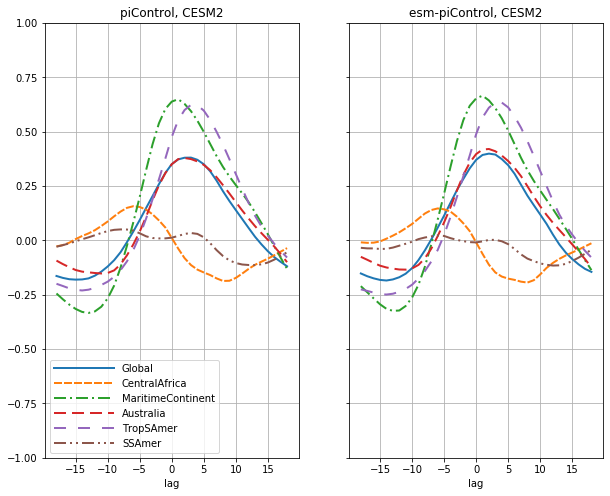

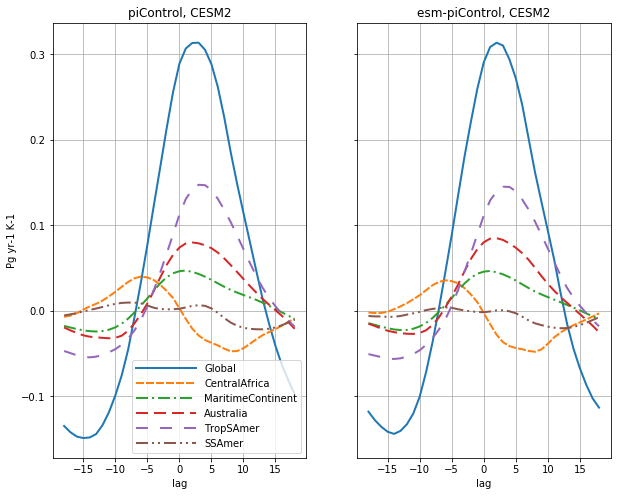

In [8]:
corr_anal(('TS', 'NEE'), ['piControl', 'esm-piControl'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=piControl-cmip5
Global: 0.580
CentralAfrica: -0.010
MaritimeContinent: 0.117
Australia: 0.205
TropSAmer: 0.179
SSAmer: -0.056
varname_x=TS, region_x=nino34, varname_y=NEE, experiment=esm-piControl-cmip5
Global: 0.559, 0.021
CentralAfrica: -0.002, -0.008
MaritimeContinent: 0.109, 0.008
Australia: 0.195, 0.010
TropSAmer: 0.174, 0.005
SSAmer: -0.050, -0.007


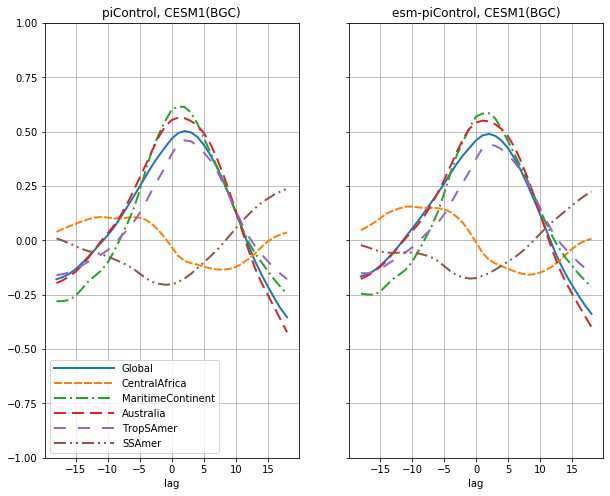

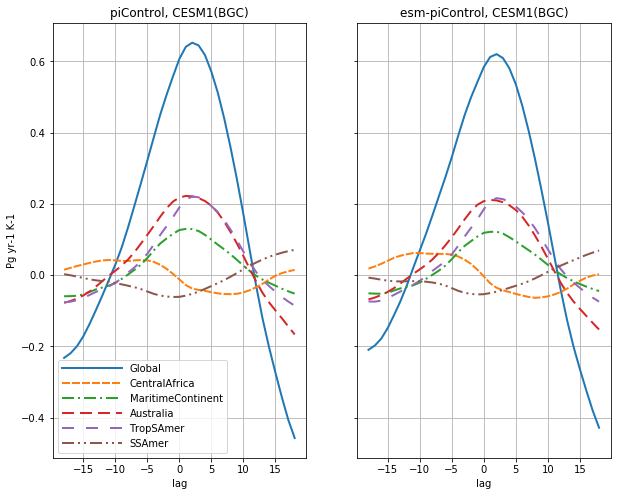

In [9]:
corr_anal(('TS', 'NEE'), ['piControl-cmip5', 'esm-piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=GPP, experiment=piControl
Global: -0.491
CentralAfrica: 0.036
MaritimeContinent: -0.051
Australia: -0.224
TropSAmer: -0.159
SSAmer: 0.036
varname_x=TS, region_x=nino34, varname_y=GPP, experiment=piControl-cmip5
Global: -0.503, 0.012
CentralAfrica: 0.099, -0.063
MaritimeContinent: -0.200, 0.149
Australia: -0.209, -0.015
TropSAmer: -0.102, -0.057
SSAmer: 0.120, -0.084


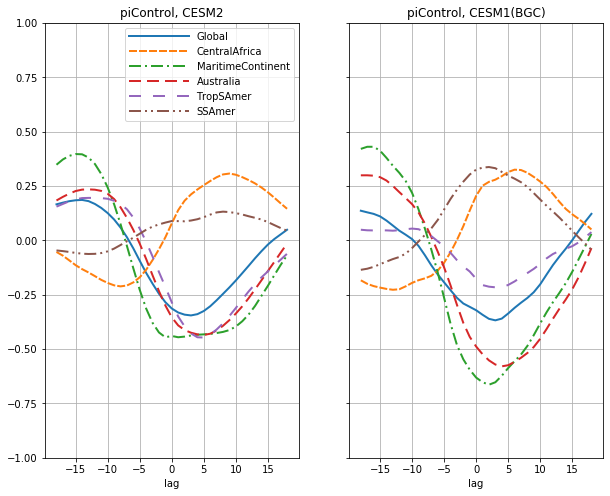

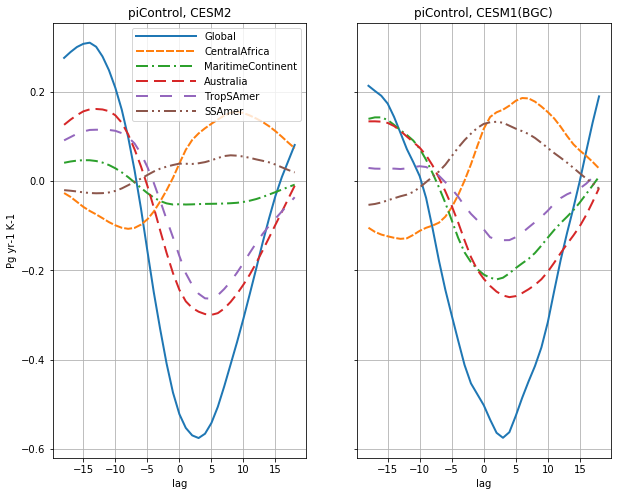

In [10]:
corr_anal(('TS', 'GPP'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=NPP, experiment=piControl
Global: -0.410
CentralAfrica: 0.030
MaritimeContinent: -0.068
Australia: -0.138
TropSAmer: -0.161
SSAmer: 0.030
varname_x=TS, region_x=nino34, varname_y=NPP, experiment=piControl-cmip5
Global: -0.458, 0.048
CentralAfrica: 0.034, -0.004
MaritimeContinent: -0.120, 0.052
Australia: -0.138, -0.000
TropSAmer: -0.158, -0.002
SSAmer: 0.050, -0.020


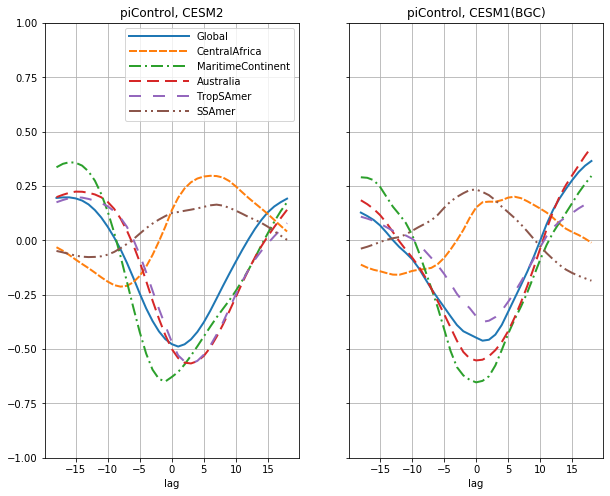

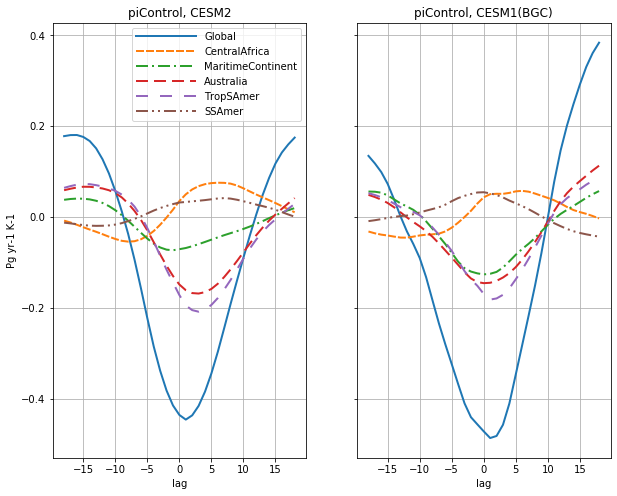

In [11]:
corr_anal(('TS', 'NPP'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=AR, experiment=piControl
Global: -0.081
CentralAfrica: 0.005
MaritimeContinent: 0.017
Australia: -0.086
TropSAmer: 0.001
SSAmer: 0.006
varname_x=TS, region_x=nino34, varname_y=AR, experiment=piControl-cmip5
Global: -0.045, -0.036
CentralAfrica: 0.065, -0.059
MaritimeContinent: -0.080, 0.097
Australia: -0.071, -0.015
TropSAmer: 0.056, -0.055
SSAmer: 0.070, -0.064


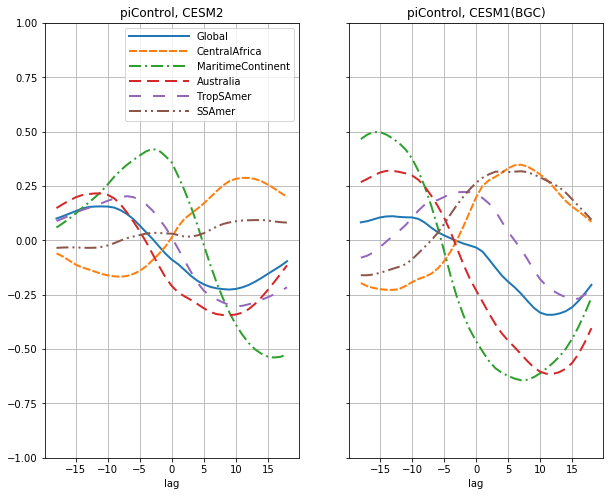

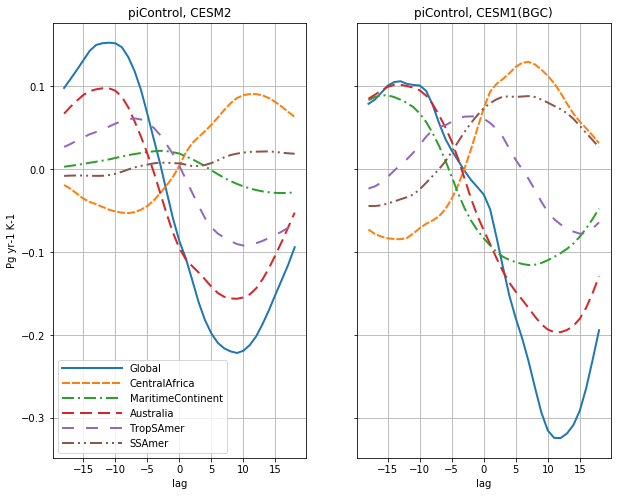

In [12]:
corr_anal(('TS', 'AR'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=TOTVEGC, experiment=piControl
Global: -0.019
CentralAfrica: -0.025
MaritimeContinent: -0.004
Australia: -0.002
TropSAmer: 0.040
SSAmer: -0.006
varname_x=TS, region_x=nino34, varname_y=TOTVEGC, experiment=piControl-cmip5
Global: -0.176, 0.157
CentralAfrica: -0.024, -0.001
MaritimeContinent: -0.036, 0.032
Australia: -0.085, 0.083
TropSAmer: -0.003, 0.044
SSAmer: 0.055, -0.061


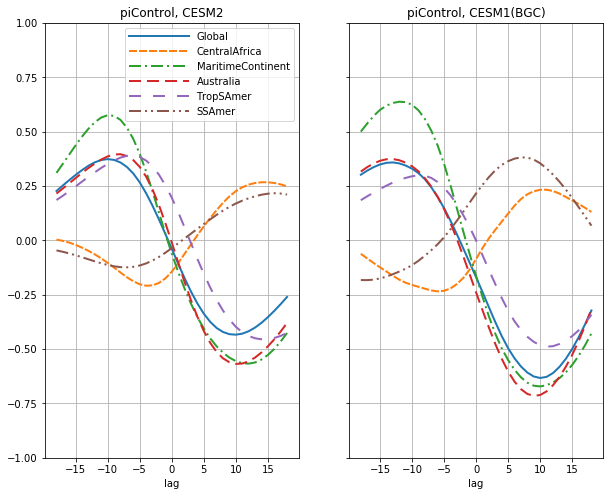

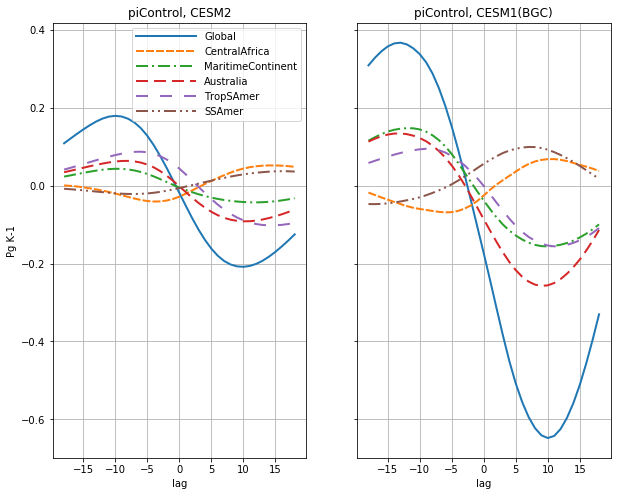

In [13]:
corr_anal(('TS', 'TOTVEGC'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=HR, experiment=piControl
Global: -0.149
CentralAfrica: 0.048
MaritimeContinent: -0.036
Australia: -0.099
TropSAmer: -0.060
SSAmer: 0.046
varname_x=TS, region_x=nino34, varname_y=HR, experiment=piControl-cmip5
Global: 0.008, -0.157
CentralAfrica: 0.029, 0.018
MaritimeContinent: -0.055, 0.019
Australia: 0.045, -0.144
TropSAmer: -0.008, -0.052
SSAmer: 0.002, 0.044


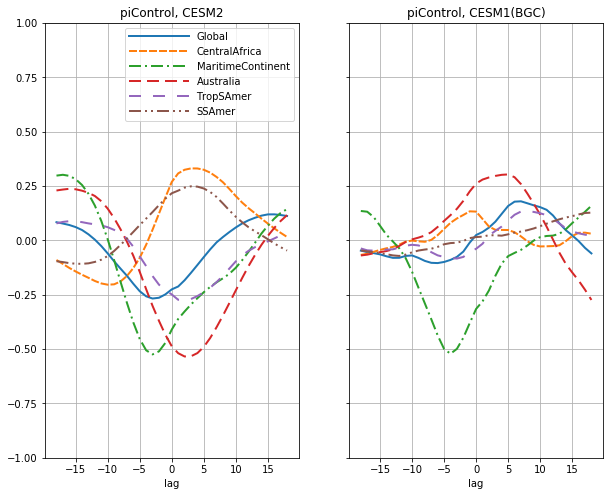

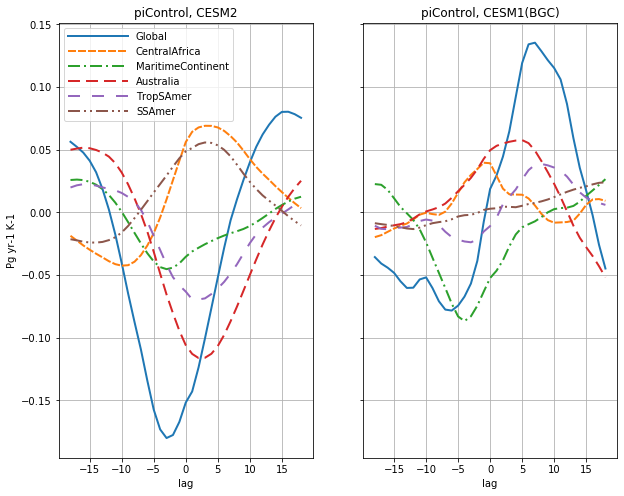

In [14]:
corr_anal(('TS', 'HR'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=COL_FIRE_CLOSS, experiment=piControl
Global: 0.005
CentralAfrica: -0.016
MaritimeContinent: 0.010
Australia: 0.028
TropSAmer: 0.004
SSAmer: -0.012
varname_x=TS, region_x=nino34, varname_y=COL_FIRE_CLOSS, experiment=piControl-cmip5
Global: 0.114, -0.110
CentralAfrica: -0.005, -0.011
MaritimeContinent: 0.052, -0.041
Australia: 0.022, 0.006
TropSAmer: 0.029, -0.025
SSAmer: -0.009, -0.004


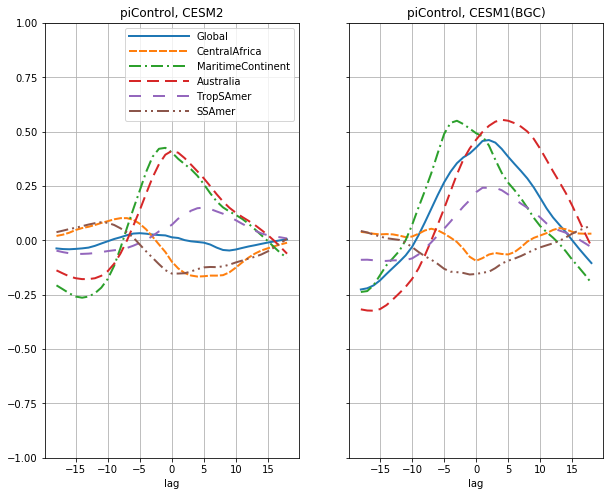

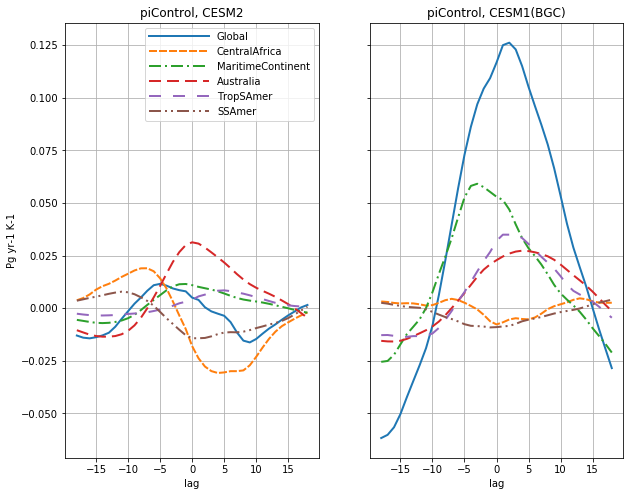

In [15]:
corr_anal(('TS', 'COL_FIRE_CLOSS'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=TOTSOMC, experiment=piControl
Global: 0.020
CentralAfrica: 0.007
MaritimeContinent: 0.001
Australia: -0.002
TropSAmer: 0.003
SSAmer: 0.003
varname_x=TS, region_x=nino34, varname_y=TOTSOMC, experiment=piControl-cmip5
Global: 0.045, -0.025
CentralAfrica: 0.010, -0.004
MaritimeContinent: 0.004, -0.004
Australia: 0.012, -0.015
TropSAmer: 0.006, -0.003
SSAmer: -0.007, 0.010


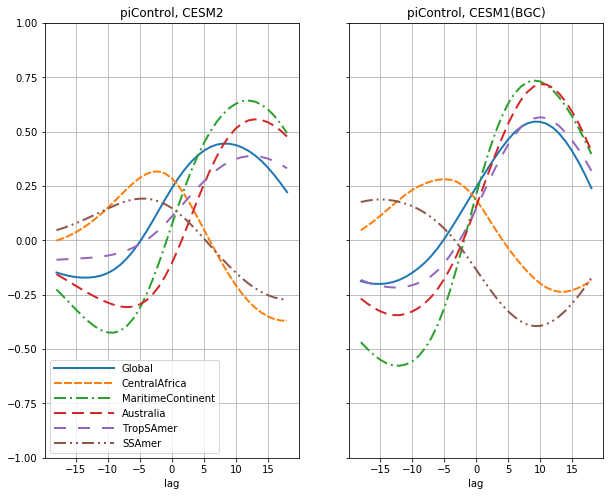

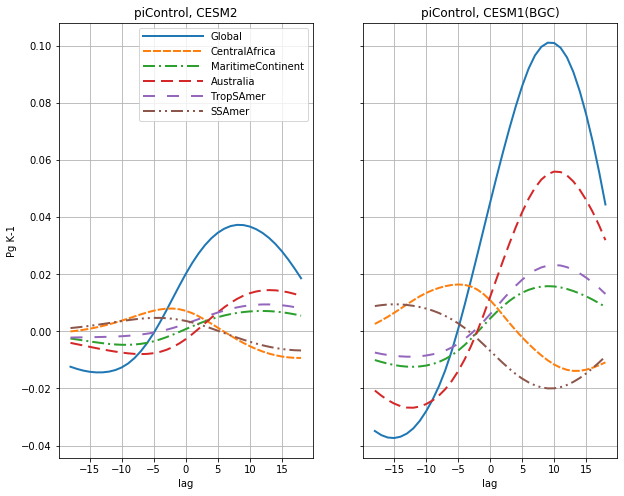

In [16]:
corr_anal(('TS', 'TOTSOMC'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=TSA, experiment=piControl
Global: 0.063
CentralAfrica: 0.124
MaritimeContinent: 0.018
Australia: 0.084
TropSAmer: 0.235
SSAmer: 0.147
varname_x=TS, region_x=nino34, varname_y=TSA, experiment=piControl-cmip5
Global: 0.091, -0.028
CentralAfrica: 0.197, -0.073
MaritimeContinent: 0.024, -0.006
Australia: 0.271, -0.187
TropSAmer: 0.227, 0.008
SSAmer: 0.096, 0.051


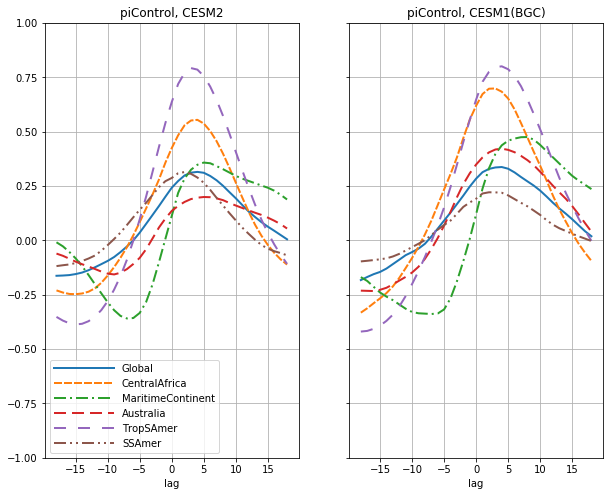

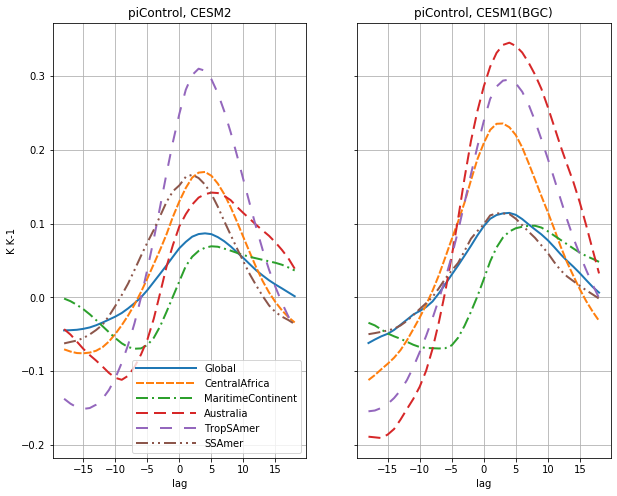

In [17]:
corr_anal(('TS', 'TSA'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=TSOI_10CM, experiment=piControl
Global: 0.062
CentralAfrica: 0.100
MaritimeContinent: 0.053
Australia: 0.136
TropSAmer: 0.233
SSAmer: 0.117
varname_x=TS, region_x=nino34, varname_y=TSOI_10CM, experiment=piControl-cmip5
Global: 0.083, -0.021
CentralAfrica: 0.186, -0.086
MaritimeContinent: 0.034, 0.018
Australia: 0.389, -0.253
TropSAmer: 0.212, 0.020
SSAmer: 0.069, 0.048


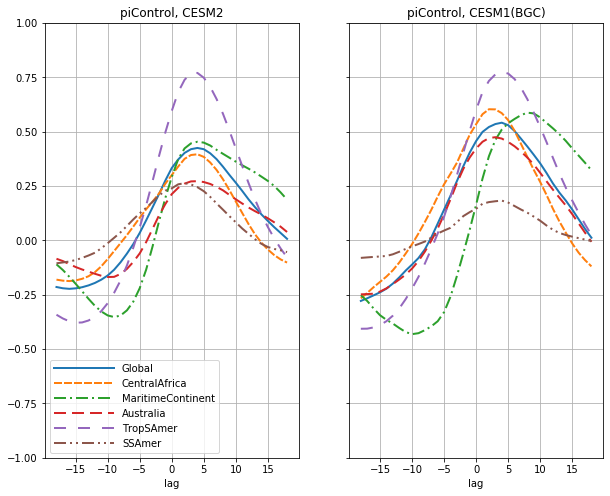

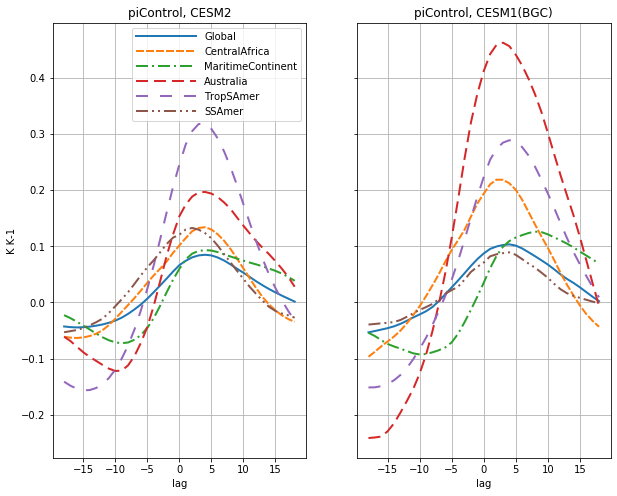

In [18]:
corr_anal(('TS', 'TSOI_10CM'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=RAIN, experiment=piControl
Global: -0.033
CentralAfrica: 0.123
MaritimeContinent: -0.355
Australia: -0.281
TropSAmer: -0.229
SSAmer: 0.053
varname_x=TS, region_x=nino34, varname_y=RAIN, experiment=piControl-cmip5
Global: -0.022, -0.011
CentralAfrica: 0.066, 0.057
MaritimeContinent: -0.262, -0.094
Australia: -0.251, -0.029
TropSAmer: -0.158, -0.071
SSAmer: 0.042, 0.011


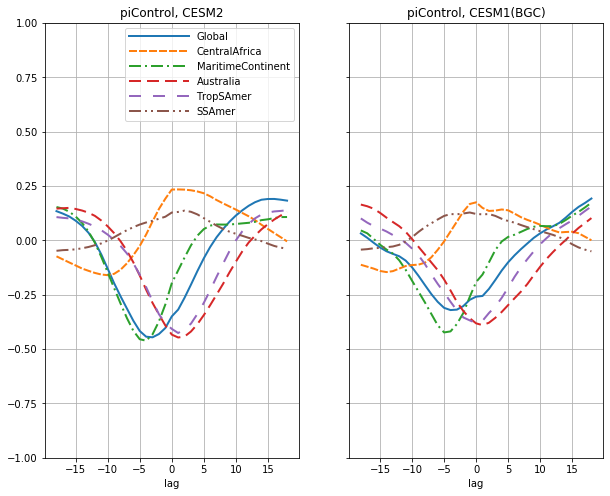

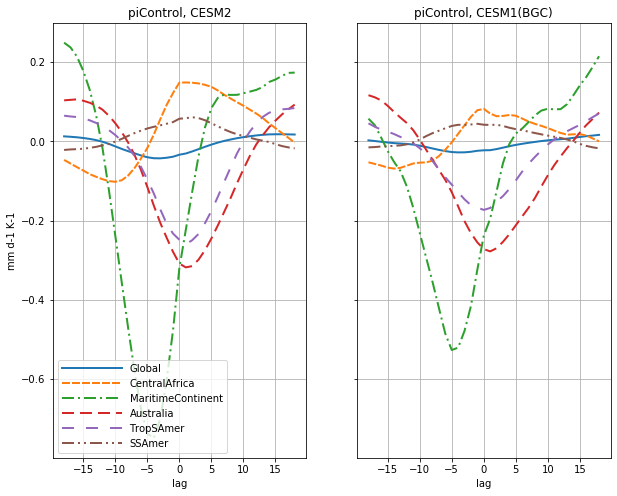

In [19]:
corr_anal(('TS', 'RAIN'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=SOILLIQ_10CM, experiment=piControl
Global: -0.029
CentralAfrica: 0.087
MaritimeContinent: -0.397
Australia: -0.375
TropSAmer: -0.158
SSAmer: 0.077
varname_x=TS, region_x=nino34, varname_y=SOILLIQ_10CM, experiment=piControl-cmip5
Global: -0.023, -0.006
CentralAfrica: 0.003, 0.084
MaritimeContinent: -0.306, -0.091
Australia: -0.295, -0.080
TropSAmer: -0.106, -0.052
SSAmer: 0.061, 0.016


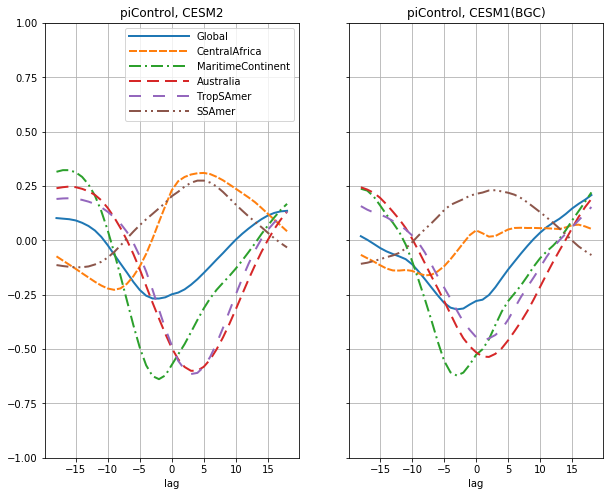

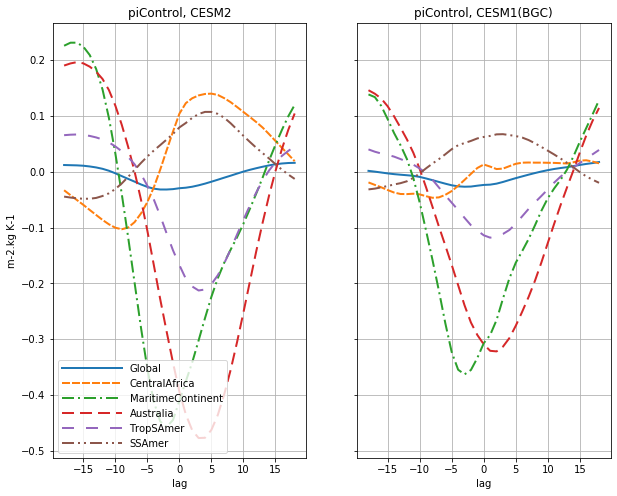

In [20]:
corr_anal(('TS', 'SOILLIQ_10CM'), ['piControl', 'piControl-cmip5'])

component_x=atm,component_y=lnd
varname_x=TS, region_x=nino34, varname_y=SOILLIQ_TOT, experiment=piControl
Global: -2.755
CentralAfrica: 1.140
MaritimeContinent: -27.984
Australia: -12.184
TropSAmer: -11.561
SSAmer: 2.394
varname_x=TS, region_x=nino34, varname_y=SOILLIQ_TOT, experiment=piControl-cmip5
Global: -1.739, -1.016
CentralAfrica: -0.836, 1.976
MaritimeContinent: -21.717, -6.267
Australia: -10.793, -1.391
TropSAmer: -7.878, -3.683
SSAmer: 1.988, 0.407


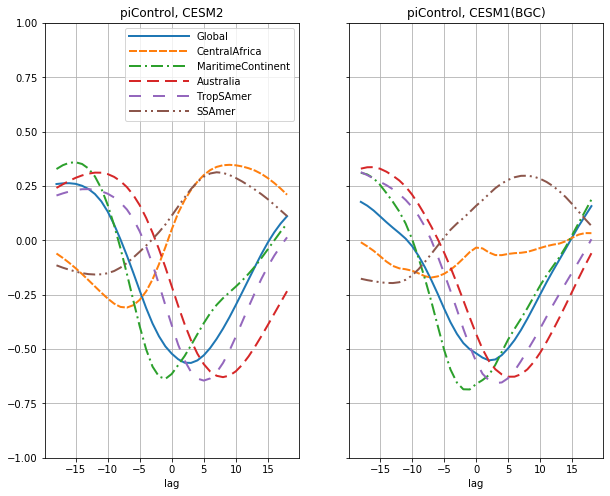

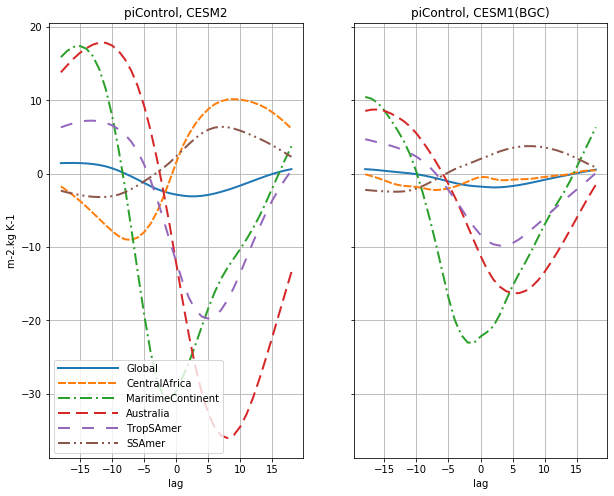

In [21]:
corr_anal(('TS', 'SOILLIQ_TOT'), ['piControl', 'piControl-cmip5'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=GPP, experiment=piControl
CentralAfrica: 0.011
MaritimeContinent: 0.002
Australia: 0.006
TropSAmer: 0.012
SSAmer: 0.011
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=GPP, experiment=piControl-cmip5
CentralAfrica: 0.017, -0.006
MaritimeContinent: 0.006, -0.005
Australia: 0.012, -0.005
TropSAmer: 0.017, -0.005
SSAmer: 0.014, -0.003


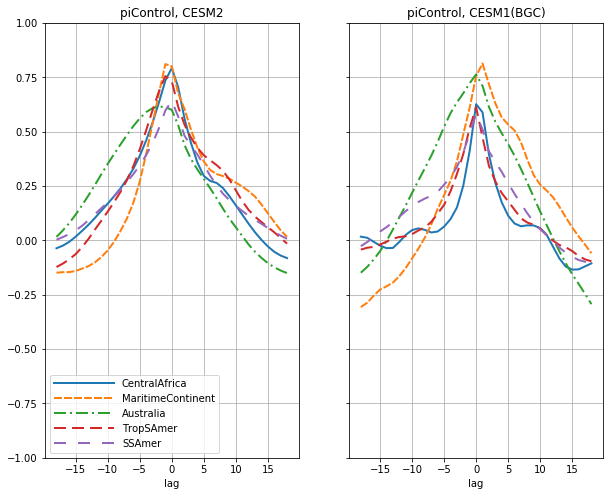

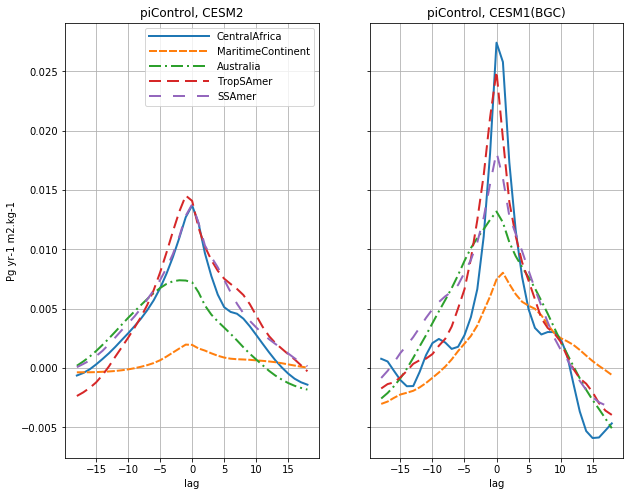

In [22]:
corr_anal(('SOILLIQ_TOT', 'GPP'), ['piControl', 'piControl-cmip5'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=HR, experiment=piControl
CentralAfrica: 0.004
MaritimeContinent: 0.001
Australia: 0.002
TropSAmer: 0.004
SSAmer: 0.005
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=HR, experiment=piControl-cmip5
CentralAfrica: 0.001, 0.003
MaritimeContinent: 0.002, -0.001
Australia: -0.002, 0.003
TropSAmer: 0.002, 0.002
SSAmer: 0.001, 0.005


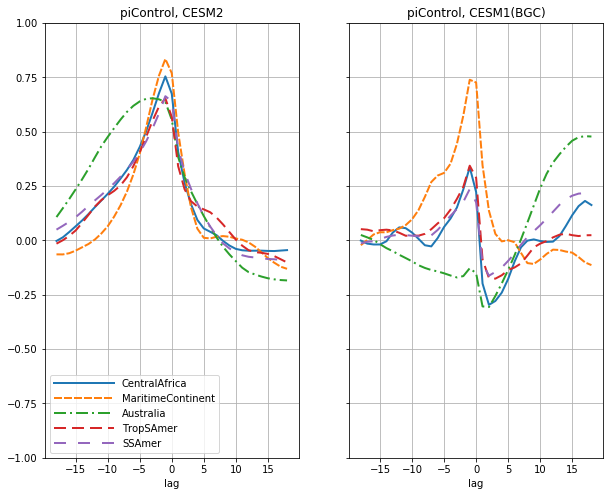

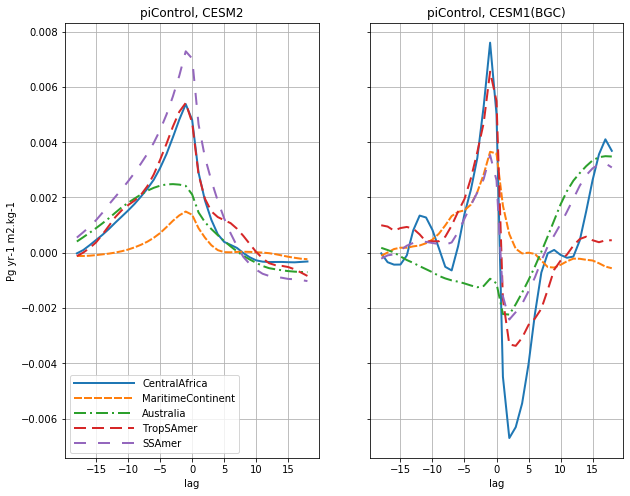

In [23]:
corr_anal(('SOILLIQ_TOT', 'HR'), ['piControl', 'piControl-cmip5'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=SOILLIQ_TOT, experiment=piControl
CentralAfrica: 0.845
MaritimeContinent: 0.808
Australia: 0.940
TropSAmer: 0.880
SSAmer: 0.867
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=SOILLIQ_TOT, experiment=piControl-cmip5
CentralAfrica: 0.671, 0.174
MaritimeContinent: 0.746, 0.062
Australia: 0.862, 0.078
TropSAmer: 0.799, 0.081
SSAmer: 0.778, 0.089


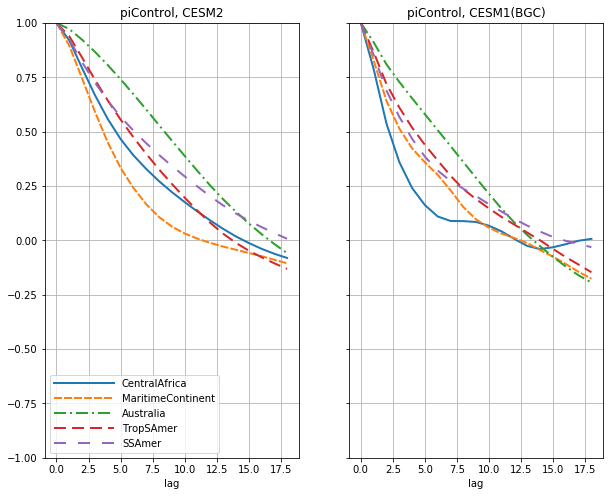

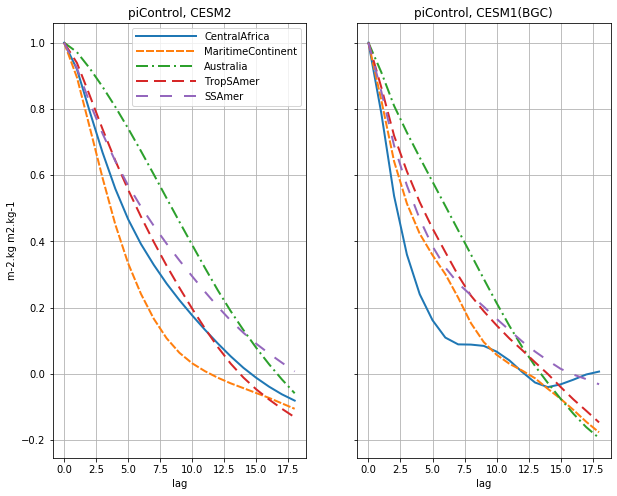

In [24]:
corr_anal(('SOILLIQ_TOT', 'SOILLIQ_TOT'), ['piControl', 'piControl-cmip5'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'],
          lag_values = range(0,18+1))